# Webscraping Amazon Toys Data

In the following jupyter notebook we will scrape the data of all the toys that are currently being sold on the amazon.in website.

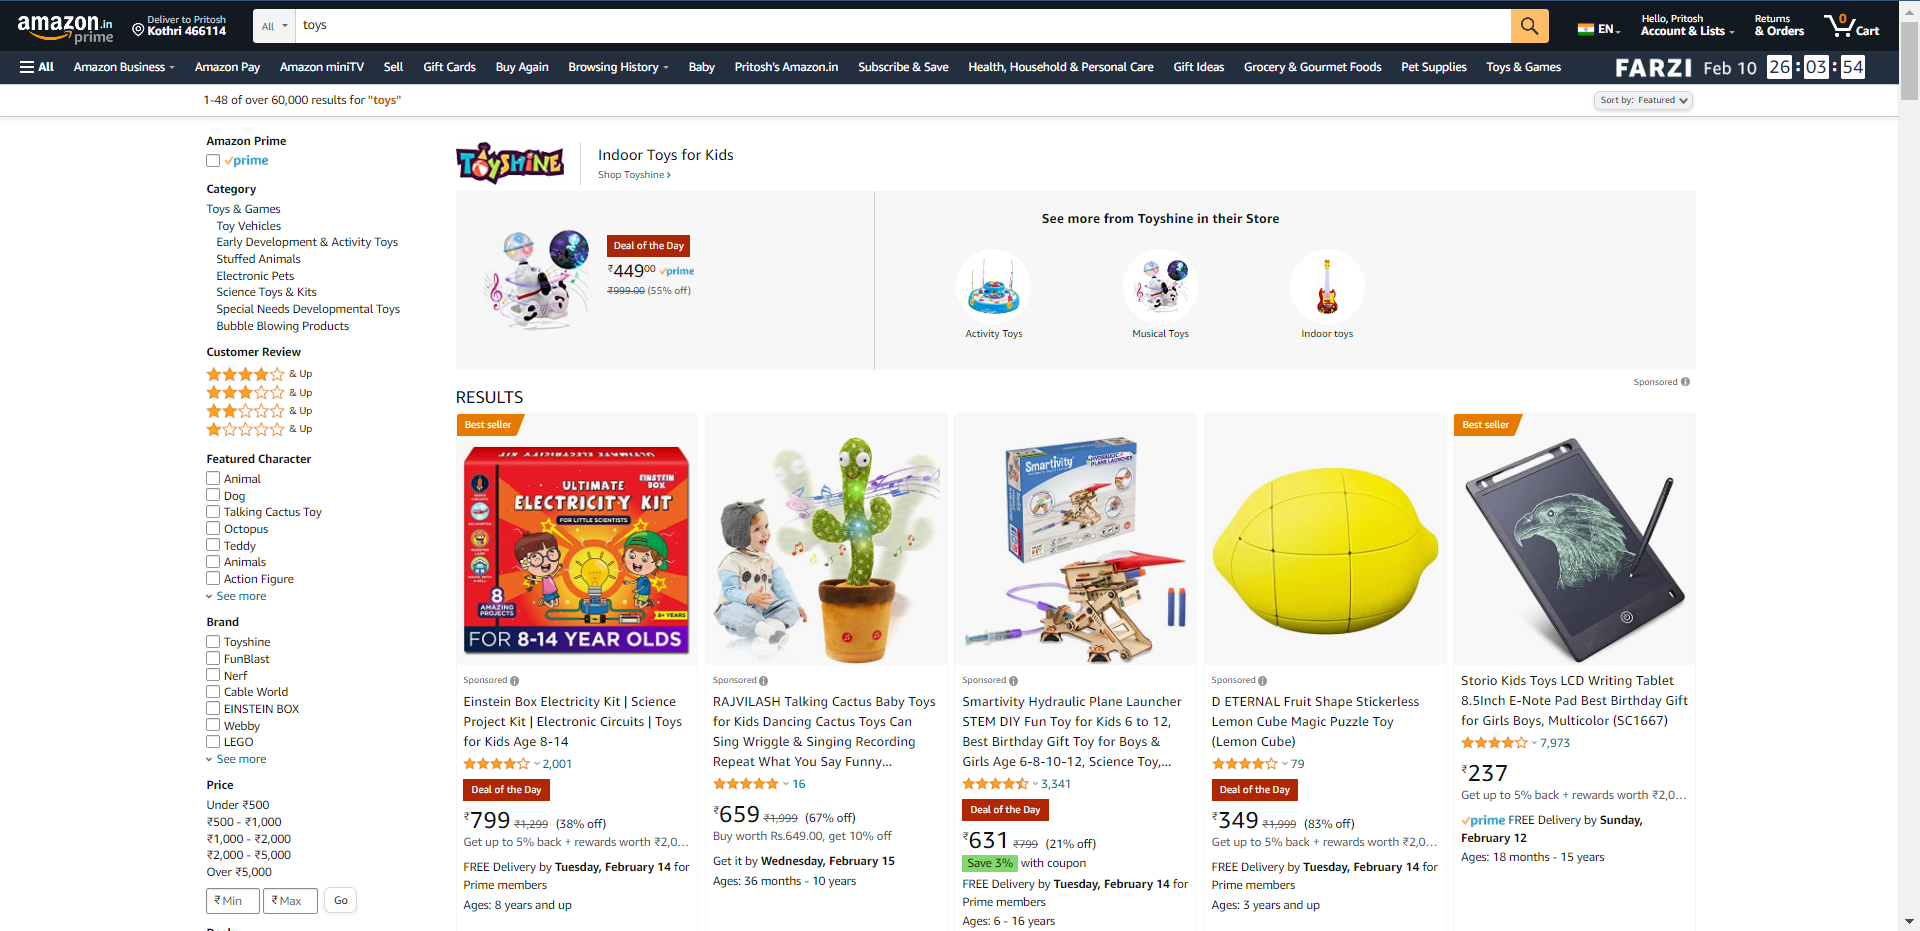


We will import the necessary libraries and modules that we are going to use.

In [1]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import numpy as np

## Data Extraction

The following code block contains separate functions to extract all the particular data of a product that you want to get such as title, price, reviews, etc.

In [2]:
# Adding my user agent
HEADERS = ({'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36', 'Accept-Language':'en-US, en;q=0.5'})


# Function to extract the website content
def getdata(url):
    # HTTPS Request
    webpage = requests.get(url, headers=HEADERS)
    soup = BeautifulSoup(webpage.content, 'html.parser')
    return soup

# Function to get the url of the next page in the website
def getnextpage(soup):
    pages = soup.find('span', {'class': 's-pagination-strip'})
    if not pages.find('span', {'class': 's-pagination-item s-pagination-next s-pagination-disabled'}):
        url = 'https://www.amazon.in' + str(pages.find('a', {'class':'s-pagination-item s-pagination-next s-pagination-button s-pagination-separator'})['href'])
        return url
    else:
        return

# Function to extract Product Title
def get_title(soup):

    try:
        # Outer Tag Object
        title = soup.find("span", attrs={"id":'productTitle'})
        
        # Inner NavigatableString Object
        title_value = title.string

        # Title as a string value
        title_string = title_value.strip()

    except AttributeError:
        title_string = ""

    return title_string

# Funtion to exract Product Price
def get_price(soup):
    try:
        price = soup.find('span',{'class':'a-price-whole'}).text.strip()
        # Clean the output string of the "." Eg. '7,799.' --> '7,799'
        price = price.replace('.','') # '7,999'
        price = price.replace(',','') # '7799'
        
    except AttributeError:
        price = ''
        
    return price

# Funtion to exract Product rating out of 5
def get_rating(soup):
    try:
        rating = soup.find('span',{'class':'a-icon-alt'}).string.strip()
        # Clean the output string of unwanted text. E.g "4.2 out of 5 stars" --> "4.2"
        rating = rating.split(' ')[0]
        
    except AttributeError:
        rating = ''
        
    return rating

        
# Function to extract the Number of User Reviews
def get_review_count(soup):
    try:
        review_text = soup.find("span", {'id':'acrCustomerReviewText'}).string.strip()
        # Clean the output string of "1,989 ratings" to only 1989 
        reviews_string = review_text.split(' ')[0] # '1,989'
        review_count = reviews_string.replace(',','') # '1989'

    except AttributeError:
        review_count = ""

    return review_count        
        
def get_age(soup):
    try:
        age = ""
        tables = soup.find_all("table", attrs={"class":'a-keyvalue prodDetTable'}) # finds all the tables in the product page
        table1 = tables[0] # The first table contains the data of the manufacturer recommended age
        body = table1.find_all('tr')
        for row_num in range(len(body)):
            if body[row_num].find('th', attrs={'class':'a-color-secondary a-size-base prodDetSectionEntry'}).text.strip() == 'Manufacturer recommended age':
                age = body[row_num].find('td', attrs={'class':"a-size-base prodDetAttrValue"}).text.strip()
                # Clean the output string '\u200e36 months - 10 years' --> '36 months - 10 years'
                age = age.strip('\u200e')   
        age = age.split(' ') # ['8', 'months', '10', 'years']
        if age[1] == 'months':
            age[0] = int(age[0]) / 12 
            age = round(age[0], 2)
        else:
            age = int(age[0])
        
    except AttributeError:
        age = ""
    except UnboundLocalError:
        age = ""
    except IndexError:
        age = ""
    return age

def get_country(soup):
    try:
        country = ""
        tables = soup.find_all("table", attrs={"class":'a-keyvalue prodDetTable'}) # finds all the tables in the product page
        table1 = tables[0] #The first table contains the data of the country of origin
        body = table1.find_all('tr')
        for row_num in range(len(body)):
            if body[row_num].find('th', attrs={'class':'a-color-secondary a-size-base prodDetSectionEntry'}).text.strip() == 'Country of Origin':
                country = body[row_num].find('td', attrs={'class':"a-size-base prodDetAttrValue"}).text.strip()
                # Clean the output string '\u200eIndia' --> 'India'
                country = country.strip('\u200e')  
        
    except AttributeError:
        country = ""
    except UnboundLocalError:
        country = ""
    except IndexError:
        country = ""
    return country
        

The above functions are generic and therefore can be used for scraping any product data on amazon.in not just the data of toys!

Now using the functions we declared above, we will create our datafram consisting of all the toys sold on the Amazon India website. 

**Note:** It will take the data from all the 7 pages and not just the first page of the serach.


In [3]:
d = {"title":[], "price":[], "rating":[], "reviews":[], 'Manufacturer recommended age':[], "country":[],'link':[]}
# the webpage URL for toys on amazon.in
url = "https://www.amazon.in/s?k=toys&ref=nb_sb_noss_1"

while True:
    data = getdata(url)
    links = data.find_all('a', attrs={'class':'a-link-normal s-underline-text s-underline-link-text s-link-style a-text-normal'})
    links_list = []

    for link in links:
        links_list.append('https://www.amazon.in' + link.get('href'))
    
    for link in links_list:
        d['link'].append(link)
        new_soup = getdata(link)

        # Function calls to display all necessary product information
        d['title'].append(get_title(new_soup))
        d['price'].append(get_price(new_soup))
        d['rating'].append(get_rating(new_soup))
        d['reviews'].append(get_review_count(new_soup))
        d['Manufacturer recommended age'].append(get_age(new_soup))
        d['country'].append(get_country(new_soup))
    url = getnextpage(data)
    if not url:
        break

amazon_df = pd.DataFrame.from_dict(d)
amazon_df

,title,price,rating,reviews,Manufacturer recommended age,country,link
0,Smartivity Hydraulic Plane Launcher STEM DIY F...,631,4.3,3341,6,India,https://www.amazon.in/sspa/click?ie=UTF8&spc=M...
1,Einstein Box Electricity Kit | Science Project...,799,4.2,2002,8,India,https://www.amazon.in/sspa/click?ie=UTF8&spc=M...
2,Jungle Magic Doodle Waterz - Reusable I Water ...,265,4.2,2487,3.0,China,https://www.amazon.in/sspa/click?ie=UTF8&spc=M...
3,Transformers Toys Studio Series 84 Deluxe Clas...,2699,4.4,3,8,Vietnam,https://www.amazon.in/sspa/click?ie=UTF8&spc=M...
4,SHINETOY ENTERTAIN KIDS TikTok Dancing Plush T...,540,4.0,1464,1.0,China,https://www.amazon.in/SHINETOY-Dancing-Chargin...
...,...,...,...,...,...,...,...
408,HUG 'n' FEEL SOFT TOYS Long Soft Lovable hugab...,146,4.1,27519,0.5,India,https://www.amazon.in/HUG-FEEL-SOFT-TOYS-birth...
409,Einstein Box Science Experiment Kit for Kids A...,699,4.3,18221,8,India,https://www.amazon.in/sspa/click?ie=UTF8&spc=M...
410,Desidiya® Dancing Cactus Voice Recorder Baby T...,699,Previous,,,India,https://www.amazon.in/sspa/click?ie=UTF8&spc=M...
411,"Toy'O Fun Marble Run Building Blocks, 84 PCS C...",599,1.8,8,3,India,https://www.amazon.in/sspa/click?ie=UTF8&spc=M...


## Data Cleaning

Now that we have the dataset it is necessary that we clean the data so that we can work easily with the data.
We will
- Remove all the rows that have an empty cell for title, price, reviews and Manufacturer recommended age.
- Change the respective data types accordingly.
- Remove any and all duplicates that the data contains.

In [4]:
amazon_df = amazon_df.replace('', np.nan)
amazon_df = amazon_df.dropna(subset=['title', 'price', 'reviews', 'Manufacturer recommended age'])
amazon_df

,title,price,rating,reviews,Manufacturer recommended age,country,link
0,Smartivity Hydraulic Plane Launcher STEM DIY F...,631,4.3,3341,6.0,India,https://www.amazon.in/sspa/click?ie=UTF8&spc=M...
1,Einstein Box Electricity Kit | Science Project...,799,4.2,2002,8.0,India,https://www.amazon.in/sspa/click?ie=UTF8&spc=M...
2,Jungle Magic Doodle Waterz - Reusable I Water ...,265,4.2,2487,3.0,China,https://www.amazon.in/sspa/click?ie=UTF8&spc=M...
3,Transformers Toys Studio Series 84 Deluxe Clas...,2699,4.4,3,8.0,Vietnam,https://www.amazon.in/sspa/click?ie=UTF8&spc=M...
4,SHINETOY ENTERTAIN KIDS TikTok Dancing Plush T...,540,4.0,1464,1.0,China,https://www.amazon.in/SHINETOY-Dancing-Chargin...
...,...,...,...,...,...,...,...
407,"Einstein Box Gift Set for Babies, Newborns and...",699,4.4,1661,1.0,India,https://www.amazon.in/Einstein-Newborns-1-3-6-...
408,HUG 'n' FEEL SOFT TOYS Long Soft Lovable hugab...,146,4.1,27519,0.5,India,https://www.amazon.in/HUG-FEEL-SOFT-TOYS-birth...
409,Einstein Box Science Experiment Kit for Kids A...,699,4.3,18221,8.0,India,https://www.amazon.in/sspa/click?ie=UTF8&spc=M...
411,"Toy'O Fun Marble Run Building Blocks, 84 PCS C...",599,1.8,8,3.0,India,https://www.amazon.in/sspa/click?ie=UTF8&spc=M...


In [5]:
amazon_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 412
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   title                         366 non-null    object 
 1   price                         366 non-null    object 
 2   rating                        366 non-null    object 
 3   reviews                       366 non-null    object 
 4   Manufacturer recommended age  366 non-null    float64
 5   country                       362 non-null    object 
 6   link                          366 non-null    object 
dtypes: float64(1), object(6)
memory usage: 22.9+ KB


In [6]:
amazon_df.astype({'price': 'int64', 'rating': 'float64', 'reviews': 'int64'}).dtypes

title                            object
price                             int64
rating                          float64
reviews                           int64
Manufacturer recommended age    float64
country                          object
link                             object
dtype: object

In [7]:
amazon_df = amazon_df.drop_duplicates(subset = ['title', 'price', 'rating', 'reviews', 'Manufacturer recommended age', 'country'])

In [8]:
amazon_df

,title,price,rating,reviews,Manufacturer recommended age,country,link
0,Smartivity Hydraulic Plane Launcher STEM DIY F...,631,4.3,3341,6.0,India,https://www.amazon.in/sspa/click?ie=UTF8&spc=M...
1,Einstein Box Electricity Kit | Science Project...,799,4.2,2002,8.0,India,https://www.amazon.in/sspa/click?ie=UTF8&spc=M...
2,Jungle Magic Doodle Waterz - Reusable I Water ...,265,4.2,2487,3.0,China,https://www.amazon.in/sspa/click?ie=UTF8&spc=M...
3,Transformers Toys Studio Series 84 Deluxe Clas...,2699,4.4,3,8.0,Vietnam,https://www.amazon.in/sspa/click?ie=UTF8&spc=M...
4,SHINETOY ENTERTAIN KIDS TikTok Dancing Plush T...,540,4.0,1464,1.0,China,https://www.amazon.in/SHINETOY-Dancing-Chargin...
...,...,...,...,...,...,...,...
396,Toyshine Transparent Bus Concept Musical and 3...,399,4.4,152,2.0,China,https://www.amazon.in/Toyshine-Transparent-Con...
398,EINSTEIN BOX for 3 Year Old Kids | Toys for Ki...,699,4.1,3326,3.0,NaN,https://www.amazon.in/Einstein-Box-Girls-Learn...
401,"Fundough - Market Place , Cutting and Moulding...",499,4.2,36,3.0,India,https://www.amazon.in/Funskool-Fun-Market-Plac...
402,"NERF Stinger Sd-1 Alpha Strike Toy Blaster, 8 ...",211,4.4,920,8.0,India,https://www.amazon.in/Stinger-Alpha-Strike-Bla...


In [9]:
amazon_df.to_csv("amazon.csv", header=True, index=False)